In [1]:
# Add Heatwave Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import ERA, Country, utils

import netCDF4

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

from scipy.interpolate import griddata
from scipy.ndimage import *

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import roc_auc_score
from skimage import transform

from eofs.standard import Eof

import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor

from pprint import pprint
import json

import calendar
import os
import re

Using TensorFlow backend.


In [2]:
# TODO: Include Cosine Lattitude Weights!!

In [3]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")
ERA5_ROOT = os.path.join(DATA_ROOT, 'ERA5')
LSM_PATH = os.path.join(ERA5_ROOT, 'landseamask_0.25deg.nc')
T2M_PATH = os.path.join(ERA5_ROOT, 't2mmax_US_1979-2018_1jan_31dec_daily_0.25deg.nc')
SST_PATH = os.path.join(ERA5_ROOT, 'sst_1979-2018_1jan_31dec_daily_2.5deg.nc')
SM1_PATH = os.path.join(ERA5_ROOT, 'sm_1_1979-2018_1jan_31dec_daily_0.25deg.nc')
SM2_PATH = os.path.join(ERA5_ROOT, 'sm_2_1979-2018_1jan_31dec_daily_0.25deg.nc')
SM3_PATH = os.path.join(ERA5_ROOT, 'sm_3_1979-2018_1jan_31dec_daily_0.25deg.nc')
SLP_PATH = os.path.join(ERA5_ROOT, 'SLP_1979-2018_1jan_31dec_daily_2.5deg.nc')

ERA_FEATURE_ROOT = os.path.join(DATA_ROOT, 'features', 'ERA')
ERA5_FEATURE_ROOT = os.path.join(DATA_ROOT, 'features', 'ERA5')

OUT_PATH = os.path.join(DATA_ROOT, 'features', 'ERA5')
PRE_PATH = os.path.join(DATA_ROOT, 'precursor/ERA5/random4_leave_4_out_1979_2018_tf1_stdp_1.0deg_60nyr_95tperc_0.85tc_1rmCPPA_2019-04-27/lags[0,15,30,50]Ev1d0p_pmd1/timeseries_robwghts')

In [4]:
LAG = 50

In [5]:
SUMMER_LEN = 60

def summer_indices(df: pd.DataFrame, extend: int=0):
    summer = []
    for year in np.unique(df.index.year):
        leap = -1 if calendar.isleap(year) else 0
        summer.append(df.loc[pd.to_datetime(f"{24+leap}-06-{year}") - pd.Timedelta(extend, 'D'):f"{22+leap}-08-{year}"])
    return pd.concat(summer).values.ravel()

def moving_average(a, n):
    ret = np.cumsum(a, axis=1)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, n:] / n

# Temperature at 2 Metres (T2M) & Eastern US Clustering

In [6]:
# Load Temperature at 2 Metres (T2M) data from disk
# Only load hottest 60 summer days of each year, as defined in summer_indices()
ERA5_KWARGS = {'time_origin': '1979-01-01', 'time_unit': 'D'}
T2M = ERA(T2M_PATH, 't2m', **ERA5_KWARGS)
T2M = ERA(T2M_PATH, 't2m', **ERA5_KWARGS, index=[summer_indices(T2M.time)])

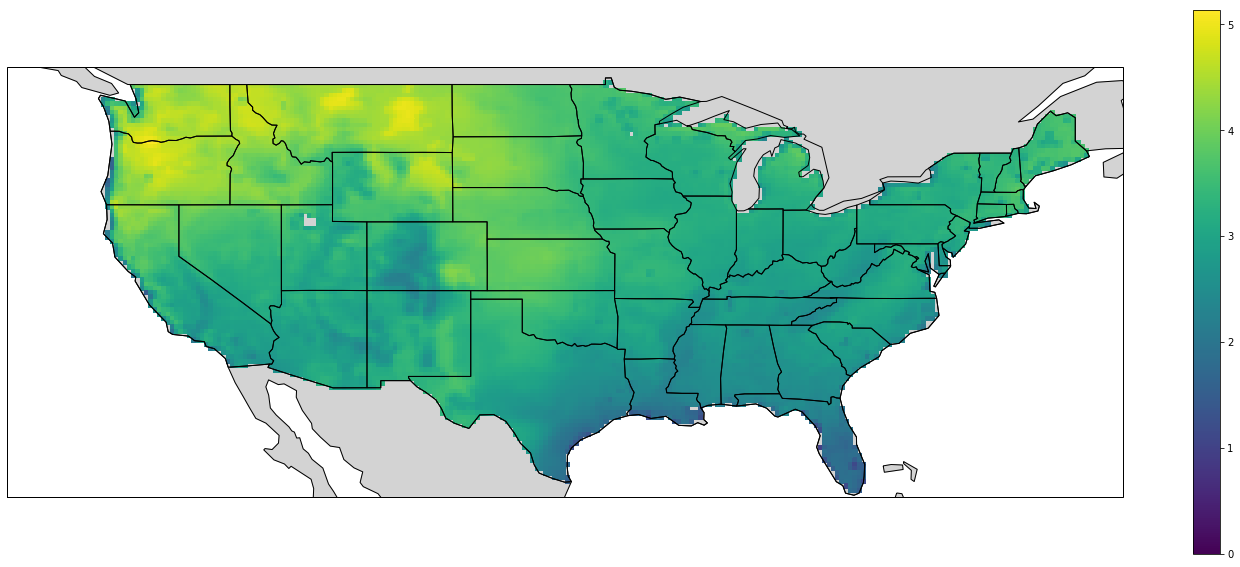

In [7]:
LSM_THRESHOLD = 0.5

# Mask US (Data is already bounded for US Mainland)
# This calculation can take a while the first time, but will be buffered..
MASK_US = binary_closing(utils.era_country_mask(T2M_PATH) == Country.US)

# Calculate Land-Sea Mask
LSM = ERA(LSM_PATH, 'lsm')
LSM = ERA(LSM_PATH, 'lsm', index=[
    None,
    slice(np.where(LSM.latitude == T2M.latitude[0])[0][0], np.where(LSM.latitude == T2M.latitude[-1])[0][0] + 1),
    slice(np.where(LSM.longitude == T2M.longitude[0] + 360)[0][0], np.where(LSM.longitude == T2M.longitude[-1] + 360)[0][0] + 1)
]).data[0]

MASK_US *= LSM >= LSM_THRESHOLD

tmp = np.std(T2M.data, 0)
tmp[~MASK_US] = np.nan

utils.plot_earth("US")
plt.pcolormesh(T2M.longitude, T2M.latitude, tmp, vmin=0)
plt.colorbar()
plt.show()

del LSM, tmp

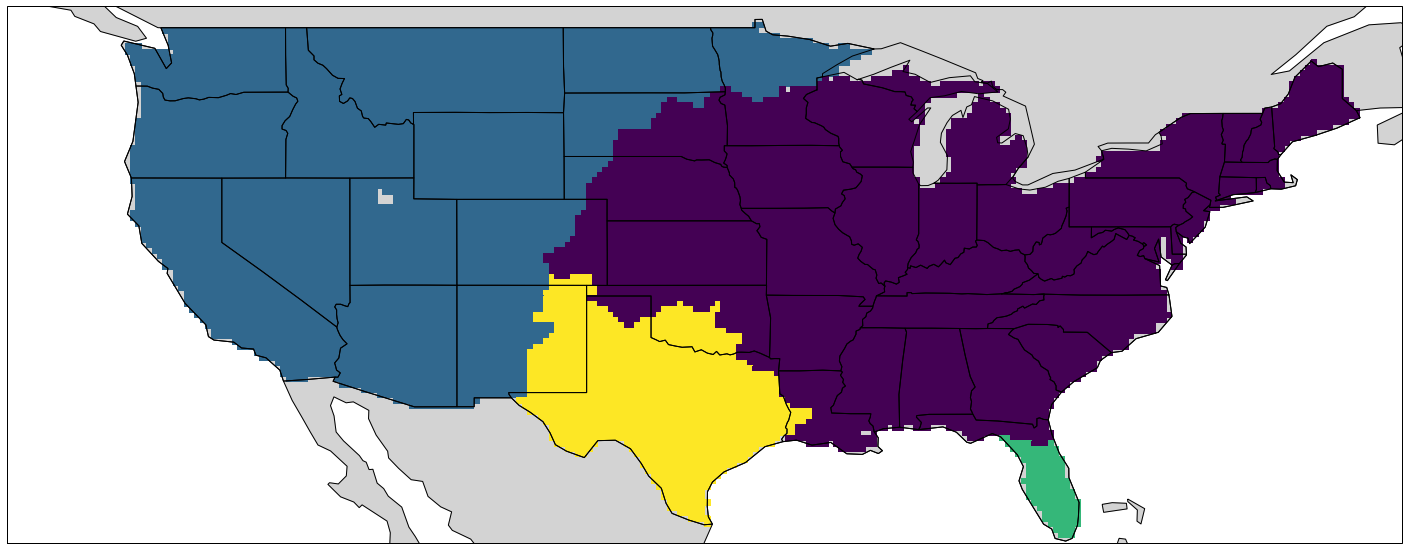

In [8]:
N = 4  # Number of Clusters

T2M_US = T2M.data[:, MASK_US]
T95_BOOL = T2M_US > np.quantile(T2M_US, 0.95, 0)

# Create Clustering to find Eastern United States
cluster = AgglomerativeClustering(N, affinity='jaccard', linkage='average')
cluster.fit(T95_BOOL.T)

# Create 2D Label Array
labels = np.empty(T2M.data.shape[1:])
labels.fill(np.nan)
labels[MASK_US] = cluster.labels_

# Find East Cluster (by looking at the maximum longitude value of each cluster and taking the max of that)
east_index = np.argmax([np.max(np.argwhere(labels==label)[:, 1]) for label in np.unique(labels[~np.isnan(labels)])])
east_mask = labels == east_index

# Plot Clusters
projection = utils.plot_earth("US")
plt.pcolormesh(T2M.longitude, T2M.latitude, labels)
plt.show()

# K-Fold Cross Validation Indices

In [9]:
# Get Unique Years
YEARS = np.unique(T2M.time.index.year)

KFOLDS = 4

# Make 'KFOLDS' groups of years, each group will be a test set
TEST_YEARS = [years.tolist() for years in np.split(YEARS, KFOLDS)]

# # Get Years from Sem's Precursors
# TEST_YEARS = [[int(year) for year in re.findall('\d{4}', path)] for path in os.listdir(PRE_PATH) if re.match(r'testyr\[(.+?)]_0.csv', path)]
# KFOLDS = len(TEST_YEARS)

INDICES = []

for test_years in TEST_YEARS:
    
    INDICES.append([[], []])
    
    for year in YEARS:
        indices = T2M.time[str(year)].values.ravel()
        
        if year in test_years:
            INDICES[-1][1].append(indices)
        else:
            INDICES[-1][0].append(indices)
            
    INDICES[-1][0] = np.concatenate(INDICES[-1][0])
    INDICES[-1][1] = np.concatenate(INDICES[-1][1])

# Heatwave (T95) Timeseries 

In [10]:
T95 = pd.DataFrame(T2M.anomaly[:, east_mask], index=T2M.time.index).quantile(0.95, 1)
T95 = (T95 - T95.mean()) / T95.std()
T95.to_csv(os.path.join(DATA_ROOT, 'heatwave_ERA5.csv'), header=False)

In [11]:
T95 = []

# Define T95 for each fold
for train_indices, test_indices in INDICES:
    # Load Train and Test Temperature at 2 Metres (T2M) Data
    T2M_US_EAST_TRAIN = T2M.data[train_indices][:, east_mask].reshape(len(train_indices)//SUMMER_LEN, SUMMER_LEN, -1)
    T2M_US_EAST_TEST = T2M.data[test_indices][:, east_mask].reshape(len(test_indices)//SUMMER_LEN, SUMMER_LEN, -1)
    
    # Calculate daily mean and standard deviation on train set
    T2M_US_EAST_TRAIN_MEAN = T2M_US_EAST_TRAIN.mean(0, keepdims=True)
    
    # Calculate Anomalies based on train mean per day
    T2M_US_EAST_ANOMALY_TRAIN = T2M_US_EAST_TRAIN - T2M_US_EAST_TRAIN_MEAN
    T2M_US_EAST_ANOMALY_TEST = T2M_US_EAST_TEST - T2M_US_EAST_TRAIN_MEAN
    
    # Calculate Spatial 95th percentile
    T95_TRAIN = np.quantile(T2M_US_EAST_ANOMALY_TRAIN, 0.95, -1).ravel()
    T95_TEST = np.quantile(T2M_US_EAST_ANOMALY_TEST, 0.95, -1).ravel()
    
    # Normalize Timeseries
    T95_TRAIN_MEAN = np.mean(T95_TRAIN)
    T95_TRAIN_STD = np.std(T95_TRAIN)
    T95_TRAIN = (T95_TRAIN - T95_TRAIN_MEAN) / T95_TRAIN_STD
    T95_TEST = (T95_TEST - T95_TRAIN_MEAN) / T95_TRAIN_STD
    
    T95.append((
        pd.DataFrame(T95_TRAIN, index=T2M.time.index[train_indices]),
        pd.DataFrame(T95_TEST, index=T2M.time.index[test_indices])
    ))

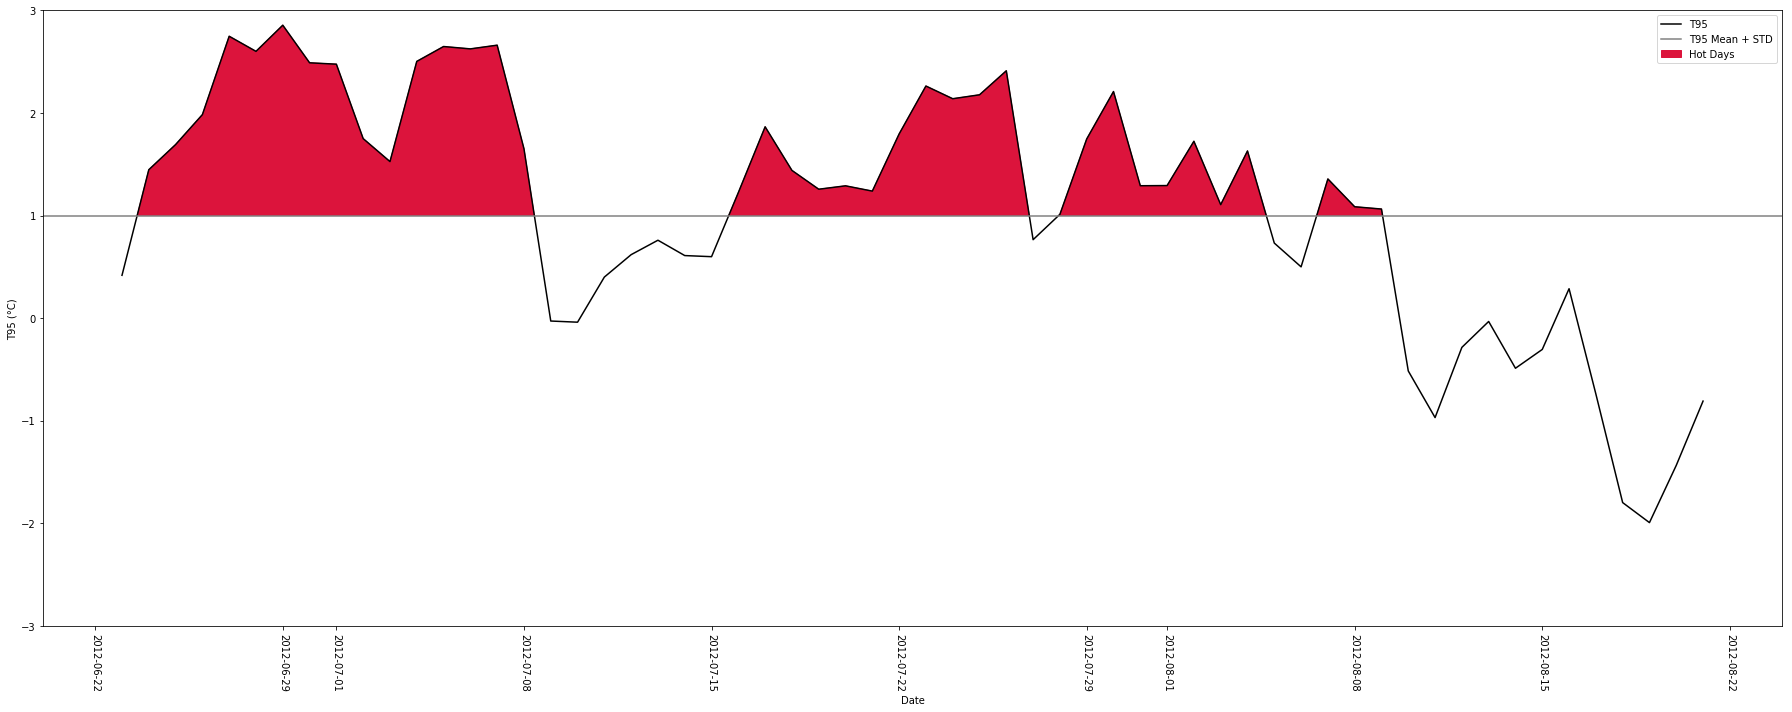

In [12]:
PLOT_YEAR = 2012
PLOT_T95 = T95[0][0][str(PLOT_YEAR)]

plt.plot(PLOT_T95, c="black", label="T95")
plt.axhline(1, c="gray", label="T95 Mean + STD")
plt.fill_between(PLOT_T95.index, [1]*len(PLOT_T95), PLOT_T95.values.ravel(),
                where=PLOT_T95.values.ravel() > 1, interpolate=True, color='crimson',
                label="Hot Days")
plt.ylabel("T95 (°C)")
plt.ylim(-3, 3)
plt.xlabel("Date")
plt.xticks(rotation=-90)
plt.legend()
plt.tight_layout()
plt.show()

# Sea Surface Temperature (SST) Timeseries

In [18]:
def sst_anomaly(window: int):

    # Load Sea Surface Temperature (SST) Data
    SST = ERA(SST_PATH, 'sst', **ERA5_KWARGS)
    SST = ERA(SST_PATH, 'sst', **ERA5_KWARGS, index=[summer_indices(SST.time, window) - LAG, slice(4, None, None)])

    # Compute SST Anomaly for each day of the year
    SST_RAW = SST.data.reshape(-1, SUMMER_LEN + window, len(SST.latitude), len(SST.longitude))
    SST_ANOMALY = SST_RAW - SST_RAW.mean(0, keepdims=True)
    
    # Compute Moving Average Over Anomaly
    if window > 0: SST_ANOMALY = moving_average(SST_ANOMALY, window)
    SST_ANOMALY = SST_ANOMALY.reshape(-1, len(SST.latitude), len(SST.longitude))

    # Normalize SST Anomalies
    SST_ANOMALY = (SST_ANOMALY - SST_ANOMALY.mean(0, keepdims=True)) / SST_ANOMALY.std(0, keepdims=True)

    # Assign 0 anomaly to Land Area's (Replace NaN with 0)
    SST_ANOMALY[np.isnan(SST_ANOMALY)] = 0
    
    return SST_ANOMALY

SST_ANOMALY_DATA = sst_anomaly(4)
SST_ANOMALY = [[SST_ANOMALY_DATA[train_idx][..., None], SST_ANOMALY_DATA[test_idx][..., None]] for train_idx, test_idx in INDICES]

# Plot Sea Surface Temperature (SST) Composite

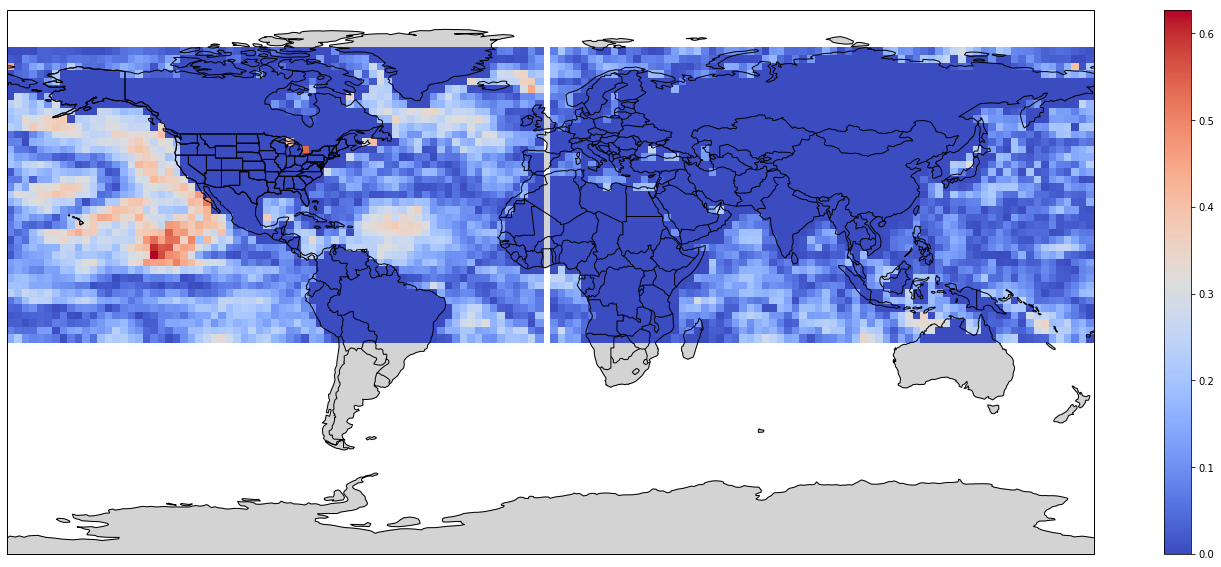

In [22]:
PLOT_FOLD = 0

SST = ERA(SST_PATH, 'sst', **ERA5_KWARGS, index=[None, slice(4, None, None)])
composite = sst_anomaly(0)[INDICES[PLOT_FOLD][0]][T95[PLOT_FOLD][0].values.ravel() > 1].mean(0)

utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, np.abs(composite), cmap='coolwarm')
plt.colorbar()
plt.show()

# Soil Moisture (SM) Timeseries

In [100]:
def sm(index: int):
    path = [SM1_PATH, SM2_PATH, SM3_PATH][index-1]
    
    SM = ERA(path, f'swvl{index}', **ERA5_KWARGS)
    SM = ERA(path, f'swvl{index}', **ERA5_KWARGS)
    
    SM_EAST_INDEX = east_mask[40:-80]
    
    SM_05 = np.quantile(SM.anomaly[..., SM_EAST_INDEX], 0.05, -1)
    
    SM_05 = (SM_05 - SM_05.mean()) / SM_05.std()
    
    return pd.DataFrame(SM_05, SM.time.index)

In [101]:
sm(1).to_csv(os.path.join(OUT_PATH, 'SM1_05.csv'), header=False)
sm(2).to_csv(os.path.join(OUT_PATH, 'SM2_05.csv'), header=False)
sm(3).to_csv(os.path.join(OUT_PATH, 'SM3_05.csv'), header=False)

# NOAA Oceanic Niño Index (ONI) Timeseries

In [ ]:
def oni(window: int):
    # Load Sea Surface Temperatures (SST) and Mask ONI Region
    SST = ERA(SST_PATH, 'sst', **ERA5_KWARGS)

    LATITUDE_MASK = np.nonzero((SST.latitude >= -5) * (SST.latitude <= 5))[0]
    LONGITUDE_MASK = np.nonzero((SST.longitude >= 190) * (SST.longitude <= 240))[0]

    SST = ERA(SST_PATH, 'sst', index=(summer_indices(SST.time, window) - LAG, LATITUDE_MASK, LONGITUDE_MASK))
    
    ONI_REGION = SST.data.reshape(-1, SUMMER_LEN + window, len(ONI_LATITUDE_MASK), len(ONI_LONGITUDE_MASK))
    ONI_REGION_ANOMALY = ONI_REGION - ONI_REGION.mean(0, keepdims=True)
    
    ONI = np.mean(ONI_REGION_ANOMALY, axis=(2, 3))
    if window > 0: ONI = moving_average(ONI, window)
    ONI = ONI.ravel()
    
    ONI = (ONI - ONI.mean()) / ONI.std()
    
    return ONI

# Pacific North American (PNA) Timeseries

In [ ]:
def pna(window: int):
    SLP = ERA(SLP_PATH, 'msl', **ERA5_KWARGS)

    PNA_1 = ERA(SLP_PATH, 'msl', **ERA5_KWARGS,
                index=(summer_indices(SLP.time, window) - LAG,
                       np.nonzero((SLP.latitude >= 15) * (SLP.latitude <= 25))[0],
                       np.nonzero((SLP.longitude >= 180) * (SLP.longitude <= 220))[0]))

    PNA_2 = ERA(SLP_PATH, 'msl', **ERA5_KWARGS,
                index=(summer_indices(SLP.time, window) - LAG,
                       np.nonzero((SLP.latitude >= 40) * (SLP.latitude <= 50))[0],
                       np.nonzero((SLP.longitude >= 180) * (SLP.longitude <= 220))[0]))

    PNA_3 = ERA(SLP_PATH, 'msl', **ERA5_KWARGS,
                index=(summer_indices(SLP.time, window) - LAG,
                       np.nonzero((SLP.latitude >= 45) * (SLP.latitude <= 60))[0],
                       np.nonzero((SLP.longitude >= 235) * (SLP.longitude <= 255))[0]))

    PNA_4 = ERA(SLP_PATH, 'msl', **ERA5_KWARGS,
                index=(summer_indices(SLP.time, window) - LAG,
                       np.nonzero((SLP.latitude >= 25) * (SLP.latitude <= 35))[0],
                       np.nonzero((SLP.longitude >= 270) * (SLP.longitude <= 290))[0]))
    
    
    pna_1 = PNA_1.data.reshape(-1, SUMMER_LEN+window, *PNA_1.shape[1:])
    pna_2 = PNA_2.data.reshape(-1, SUMMER_LEN+window, *PNA_2.shape[1:])
    pna_3 = PNA_3.data.reshape(-1, SUMMER_LEN+window, *PNA_3.shape[1:])
    pna_4 = PNA_4.data.reshape(-1, SUMMER_LEN+window, *PNA_4.shape[1:])
    
    pna_1 = (pna_1 - pna_1.mean(0, keepdims=True)).mean(axis=(2, 3))
    pna_2 = (pna_2 - pna_2.mean(0, keepdims=True)).mean(axis=(2, 3))
    pna_3 = (pna_3 - pna_3.mean(0, keepdims=True)).mean(axis=(2, 3))
    pna_4 = (pna_4 - pna_4.mean(0, keepdims=True)).mean(axis=(2, 3))
    
    pna = (pna_1 - pna_2 + pna_3 - pna_4)
    
    if window > 0: pna = moving_average(pna, window)
    pna = pna.ravel()
    
    return pna
    
pna(30).shape

# Pacific Decedal Oscilation (PDO) Timeseries

In [ ]:
def pdo(window: int):
    SST = ERA(SST_PATH, 'sst', **ERA5_KWARGS)
    
    LATITUDE_MASK = np.nonzero((SST.latitude >= 20) * (SST.latitude <= 50))[0]
    LONGITUDE_MASK = np.nonzero((SST.longitude >= 160) * (SST.longitude <= 230))[0]
    
    SST = ERA(SST_PATH, 'sst', index=(summer_indices(SST.time, window) - LAG, LATITUDE_MASK, LONGITUDE_MASK))
    
    PDO_REGION = SST.data.reshape(-1, SUMMER_LEN+window, *SST.shape[1:])
    PDO_REGION_ANOMALY = PDO_REGION - PDO_REGION.mean(0, keepdims=True)
    
    PDO = (PDO_REGION_ANOMALY * Eof(PDO_REGION_ANOMALY).eofs()[0]).mean(axis=(2, 3))
    
    if window > 0: PDO = moving_average(PDO, window)
    PDO = PDO.ravel()
    
    PDO = (PDO - PDO.mean()) / PDO.std()
    
    return PDO

# Convolutional Neural Network

In [27]:
# CNN Hyperparameters #

LOSS = 'binary_crossentropy'
OPTIMIZER = keras.optimizers.Adam(lr=2.7E-4)
REGULARIZER = keras.regularizers.l1_l2(l1=6.3E-2, l2=9.8E-2)
ACTIVATION = tf.nn.relu
ACTIVATION_OUTPUT = tf.nn.sigmoid
CONVOLUTION_KWARGS = {'kernel_size': 3, 'padding': 'same', 'kernel_regularizer': REGULARIZER}

# Model Creation #
def model():
    
    # Sequential Model
    model = keras.models.Sequential()
    
    # Input Layer (Specifying Input Shape here, hacky and nice!)
    model.add(keras.layers.Activation('linear', input_shape=(len(SST.latitude), len(SST.longitude), 1)))
    
    def convolution(filters: int, n: int, dropout: float = 0.0):
        for i in range(n):
            model.add(keras.layers.Convolution2D(filters, **CONVOLUTION_KWARGS))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Activation(ACTIVATION))
            
        model.add(keras.layers.MaxPooling2D(2))
        
        if dropout:
            model.add(keras.layers.Dropout(dropout))
            
    def dense(units: int, dropout: float = 0.0):
        model.add(keras.layers.Dense(units, kernel_regularizer=REGULARIZER))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
        if dropout:
            model.add(keras.layers.Dropout(dropout))
    
    convolution(2, 2, 0.2)
    convolution(4, 2, 0.3)
    convolution(8, 1, 0.4)
    
    model.add(keras.layers.Flatten())
    
    dense(100, 0.5)
    
    model.add(keras.layers.Dense(1, activation=ACTIVATION_OUTPUT, name="output"))
    model.compile(loss=LOSS, optimizer=OPTIMIZER)
    
    return model
    
model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_78 (Activation)   (None, 40, 144, 1)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 40, 144, 2)        20        
_________________________________________________________________
batch_normalization_67 (Batc (None, 40, 144, 2)        8         
_________________________________________________________________
activation_79 (Activation)   (None, 40, 144, 2)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 40, 144, 2)        38        
_________________________________________________________________
batch_normalization_68 (Batc (None, 40, 144, 2)        8         
_________________________________________________________________
activation_80 (Activation)   (None, 40, 144, 2)        0         
__________

In [28]:
for (X_train, X_test), (y_train, y_test) in zip(SST_ANOMALY, T95):
    print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))
    
    # Make Binary Labels
    y_train = (y_train > 1).values
    y_test = (y_test > 1).values
    
    class Callback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
                print(" -> AUC:",
                  roc_auc_score(y_train, self.model.predict(X_train)),
                  roc_auc_score(y_test, self.model.predict(X_test)))

    cnn = model()
    cnn.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[Callback()], shuffle=True, epochs=15)

((1800, 40, 144, 1), (1800, 1)) ((600, 40, 144, 1), (600, 1))
Train on 1800 samples, validate on 600 samples
Epoch 1/15
1800/1800 [==============================] - 10s 6ms/step - loss: 183.5722 - val_loss: 148.0595
 -> AUC: 0.5333405606598549 0.4763657888657889
Epoch 2/15
1800/1800 [==============================] - 7s 4ms/step - loss: 120.2427 - val_loss: 92.9395
 -> AUC: 0.5532439403384196 0.48943173943173934
Epoch 3/15
1800/1800 [==============================] - 7s 4ms/step - loss: 72.1986 - val_loss: 52.4382
 -> AUC: 0.5947954214886486 0.4983252483252484
Epoch 4/15
1800/1800 [==============================] - 7s 4ms/step - loss: 38.2217 - val_loss: 25.3448
 -> AUC: 0.6776793054539214 0.5028153153153153
Epoch 5/15
1800/1800 [==============================] - 7s 4ms/step - loss: 17.0275 - val_loss: 10.3867
 -> AUC: 0.7093937176464211 0.4911931161931161
Epoch 6/15
1800/1800 [==============================] - 7s 4ms/step - loss: 7.7749 - val_loss: 6.4301
 -> AUC: 0.68007787444327 0.6

KeyboardInterrupt: 

In [ ]:
# Class Activation Map
def CAM(model, X):
    
    last_convolution = [layer for layer in model.layers if isinstance(layer, keras.layers.Convolution2D)][-1]
    result = np.zeros(last_convolution.output.shape[1:-1])
    
    gradients = keras.backend.gradients(model.output, last_convolution.output)[0]
    gradients_mean = keras.backend.mean(gradients, axis=(0, 1, 2))
    iterate = keras.backend.function([model.input], [gradients_mean, last_convolution.output[0]])

    for counter, x in enumerate(X):
        activation, output = iterate([x[None, ...]])
        for i in range(gradients_mean.shape[0]):
            output[..., i] += activation[i]
            
        result += output.mean(-1)
    
    return transform.resize(result, X.shape[1:-1])

# Train Activation
utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, CAM(cnn, X_train[y_train.ravel()])[:-4])
plt.colorbar()
plt.show()

# Test Activation
utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, CAM(cnn, X_test[y_test.ravel()])[:-4])
plt.colorbar()
plt.show()